In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
train_df = pd.read_csv('./data/regression_train.csv')
test_df = pd.read_csv('./data/regression_test.csv')
concat_df = pd.concat([train_df, test_df])

#### Analyze

In [3]:
concat_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,174000
1,80,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,135500
2,160,FV,NaN,5105,Pave,NaN,IR2,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,148800
3,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
4,50,RL,78.0,10496,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,1,2007,WD,Normal,143000


heatmap

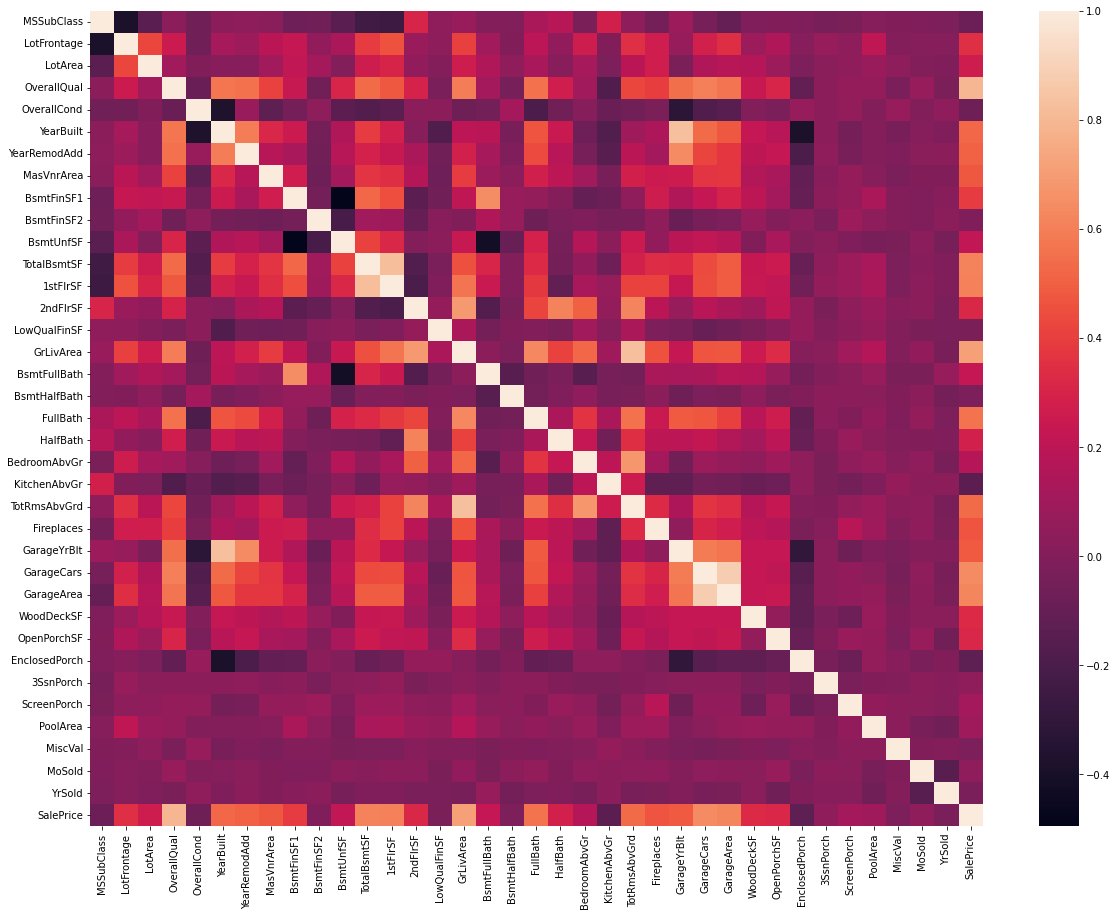

In [4]:
plt.figure(figsize=(20*1,15*1))
sns.heatmap(concat_df.corr())
plt.show()

#### Get best correlations

In [5]:
corr_matrix = concat_df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
tuples_with_saleprice = [tup for tup in sol.keys() if 'SalePrice' in tup]

sol[tuples_with_saleprice]

# Remove features???? Why remove one????? Why find them with highest correlations and remove them???? why??????


C:\Users\mimslade\AppData\Local\Temp/ipykernel_19072/850915546.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))


OverallQual    SalePrice    0.790913
GrLivArea      SalePrice    0.708478
GarageCars     SalePrice    0.640189
GarageArea     SalePrice    0.623305
TotalBsmtSF    SalePrice    0.613784
1stFlrSF       SalePrice    0.606246
FullBath       SalePrice    0.560458
TotRmsAbvGrd   SalePrice    0.533377
YearBuilt      SalePrice    0.522590
YearRemodAdd   SalePrice    0.506816
GarageYrBlt    SalePrice    0.486046
MasVnrArea     SalePrice    0.478019
Fireplaces     SalePrice    0.466750
BsmtFinSF1     SalePrice    0.387226
LotFrontage    SalePrice    0.351529
WoodDeckSF     SalePrice    0.324238
2ndFlrSF       SalePrice    0.318814
OpenPorchSF    SalePrice    0.315125
HalfBath       SalePrice    0.283596
LotArea        SalePrice    0.263905
BsmtFullBath   SalePrice    0.227723
BsmtUnfSF      SalePrice    0.213995
BedroomAbvGr   SalePrice    0.168161
KitchenAbvGr   SalePrice    0.135819
EnclosedPorch  SalePrice    0.128403
ScreenPorch    SalePrice    0.111639
PoolArea       SalePrice    0.092469
M

### Handle null values

#### 1. threshold for columns (if null values is over 50 % of column)

In [6]:
series = concat_df.isnull().sum()
series_filtered = series[series > 0]

total_rows = concat_df.shape[0]
threshold = 0.5
series_filtered_mask = (series_filtered / total_rows) > threshold

columns_to_remove = series_filtered[series_filtered_mask].keys()

concat_df.drop(columns_to_remove, inplace=True, axis=1)


print(f'removed {columns_to_remove}')

removed Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


#### 2. Threshold for rows (if row has over 10 missing values)

In [7]:
null_mask =  ~(concat_df.isnull().sum(axis=1) > 10)
filtered_df = concat_df[null_mask]

print(f'removed {concat_df.shape[0] - filtered_df.shape[0]} rows')

removed 6 rows


In [8]:
filtered_df['SaleType']


0      WD
1      WD
2      WD
3      WD
4      WD
       ..
454    WD
455    WD
456    WD
457    WD
458    WD
Name: SaleType, Length: 1453, dtype: object

#### 3. Change empty strings to most frequent class.

In [9]:
filtered_df.dtypes.unique()


array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [10]:
mask = filtered_df.dtypes == 'O'
columns_to_string = filtered_df.select_dtypes('O')

for column in columns_to_string:

    most_frequent = filtered_df[column].value_counts().keys()[0]

    filtered_df[column] = filtered_df[column].fillna(most_frequent)
    



C:\Users\mimslade\AppData\Local\Temp/ipykernel_19072/148844523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].fillna(most_frequent)


### One-hot encoding on strings

In [11]:
mask = filtered_df.dtypes == 'O'
string_datatype_df = filtered_df.select_dtypes('O')

for col_name in string_datatype_df:
    one_hot_df = pd.get_dummies(string_datatype_df[col_name])
    filtered_df = pd.concat([filtered_df, one_hot_df], axis=1).drop(col_name, axis=1)

In [12]:
filtered_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

we still have nan values...

In [13]:
import numpy as np
mask = filtered_df.isnull().sum() > 0
columns = filtered_df.columns[mask]
columns_to_fix = filtered_df[columns]

for column in columns_to_fix:
    mean = columns_to_fix[column].mean()
    filtered_df[column] = columns_to_fix[column].replace(np.NAN, mean)

Check later: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Test to remove columns when training,
for example one column to frequency instead.

In [14]:
true_mask = filtered_df['MasVnrArea'] == 0

total = len(true_mask) 
total_zero = len([c for c in true_mask if c])

total_zero / total

0.5877494838265658

#### Model

In [24]:
y = filtered_df['SalePrice']
x = filtered_df.drop('SalePrice', axis=1)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [29]:
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion="mse")
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=20)

In [36]:
prediction = forest.predict(x_test)

print(y_train.shape)
print(prediction.shape)
score = mean_squared_error(y_test, prediction)

(1162,)
(291,)
933706415.6193657


(291,)


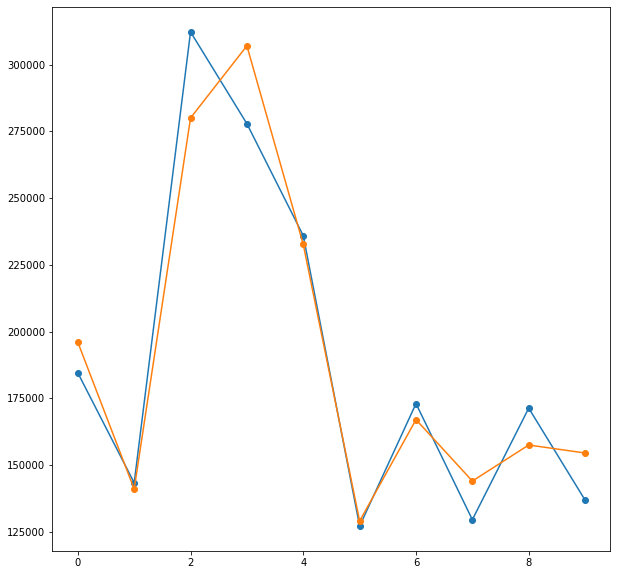

In [62]:
#print(min(prediction))
#print(max(prediction))
#print(np.mean(prediction))


#print(prediction[:10])
#print(abs(y_test[:10] - prediction[:10]))


#print(prediction[:10])
#print(y_test[:10])

figure = plt.figure(figsize=(10, 10))

length = len(prediction[:10])
print(prediction.shape)
plt.plot(range(length), prediction[:10], marker='o')
plt.plot(range(length), y_test[:10], marker='o')
plt.show()

In [77]:
deviations = abs(y_test - prediction) / y_test
print(f'The worst result was:  {np.max(deviations)  * 100} %')
print(f'The best result was:   {np.min(deviations)  * 100} %')
print(f'The mean deviation is: {np.mean(deviations) * 100} %')

The worst result was: 145.20460863070156 %
The best result was:  0.11712418621815868 %
The mean deviation is 11.123277057579035 %
